In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [2]:
# importando o dataset
covid = pd.read_csv(r'caso.csv', encoding = "utf-8")
covid.describe()

,confirmed,deaths,order_for_place,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
count,441580.000000,441580.000000,441580.000000,4.395410e+05,4.395410e+05,429678.000000,441580.000000
mean,434.457441,18.833450,45.693168,1.224538e+05,3.157370e+06,360.807330,0.046762
std,5535.380670,289.431766,29.934186,1.174799e+06,1.011723e+06,660.918303,0.128928
min,0.000000,0.000000,1.000000,7.810000e+02,1.100000e+01,0.002180,0.000000
25%,3.000000,0.000000,21.000000,7.173000e+03,2.500809e+06,28.946910,0.000000
50%,15.000000,0.000000,42.000000,1.584600e+04,3.136702e+06,118.868640,0.000000
75%,79.000000,2.000000,67.000000,3.511100e+04,4.106902e+06,408.120412,0.040000
max,529006.000000,22710.000000,155.000000,4.591905e+07,5.300108e+06,15717.926930,1.000000


In [3]:
# vamos começar pelo pre processamento de dados

In [4]:
# olhando para o tamanho do dataset vemos que temos 441580 linhas e 12 colunas 
# mas estaremos usando apenas uma fração desses dados, Recife e São Paulo 
# também adicionaremos outras colunas que acharmos necessário
covid.shape

(441580, 12)

In [5]:
# como ha dados com tipos object, o que nao pode ser bom pra categorizar, vamos mudar pra tipo categorico
covid.dtypes

date                               object
state                              object
city                               object
place_type                         object
confirmed                           int64
deaths                              int64
order_for_place                     int64
is_last                              bool
estimated_population_2019         float64
city_ibge_code                    float64
confirmed_per_100k_inhabitants    float64
death_rate                        float64
dtype: object

In [6]:
# o nosso próximo passo eh ver a quantidade de elementos nulos em cada coluna e podemos observar que ha 4 colunas bastante dados nulos 
print(covid.isnull().sum())

date                                  0
state                                 0
city                               3706
place_type                            0
confirmed                             0
deaths                                0
order_for_place                       0
is_last                               0
estimated_population_2019          2039
city_ibge_code                     2039
confirmed_per_100k_inhabitants    11902
death_rate                            0
dtype: int64


In [7]:
covidRecife = covid[covid.city=='Recife']
covidRecife.isnull().sum()

date                              0
state                             0
city                              0
place_type                        0
confirmed                         0
deaths                            0
order_for_place                   0
is_last                           0
estimated_population_2019         0
city_ibge_code                    0
confirmed_per_100k_inhabitants    0
death_rate                        0
dtype: int64

In [8]:
covidSP = covid[covid.city=='São Paulo']
covidSP.isnull().sum()

date                              0
state                             0
city                              0
place_type                        0
confirmed                         0
deaths                            0
order_for_place                   0
is_last                           0
estimated_population_2019         0
city_ibge_code                    0
confirmed_per_100k_inhabitants    0
death_rate                        0
dtype: int64

In [9]:
# ajustando tipos dos dados
covid['date'] = covid['date'].astype('category') 
covid['state'] = covid['state'].astype('category') 
covid['city'] = covid['city'].astype('category') 
covid['place_type'] = covid['place_type'].astype('category') 
covid.dtypes

date                              category
state                             category
city                              category
place_type                        category
confirmed                            int64
deaths                               int64
order_for_place                      int64
is_last                               bool
estimated_population_2019          float64
city_ibge_code                     float64
confirmed_per_100k_inhabitants     float64
death_rate                         float64
dtype: object

In [10]:
# como vimos acima que os dados que iremos trabalhar nao tem nenhum dado ausente, decidimos por limpar o dataset original com instâncias com ao menos 1 coluna com dado ausente
covid = covid.dropna()
covid.shape

(425978, 12)

In [11]:
# o nosso objetivo neste trabalho eh analisar especificamente as cidade de Recife e São Paulo, e como vimos, os dados nao apresentam falha com relação a elementos nulos, por isso a imputação de dados não vai ser necessaria. 

# sobre detecção de outliers ...

In [12]:
# uma estatística importante no nosso trabalho eh o número de mortes por dia, mas isso nao tem no dataset, por isso criamos esta função que adiciona esta coluna usando o metodo diff

# pegando os dados de Recife, resetando o index e adicionando as colunas
covidRecife = covidRecife.sort_values(by=['date'], ascending=True)
covidRecife.reset_index(inplace=True, drop=True)

#first try with a for loop
# def sub_column_value(newcolumn, subcolumn, table):
#     table[newcolumn] = 0
#     for index, i in enumerate(subcolumn):
#         if index > 0:
#             value = (subcolumn[index] - subcolumn[index-1])
#             if value > 0:
#                 table[newcolumn][index] = value
#             else:
#                 table[newcolumn][index] = 0

# sub_column_value('deaths_per_day', covidRecife.deaths, covidRecife)

# using pandas diff to calculate the difference between consecutive rows
covidRecife['deaths_per_day'] = covidRecife.deaths.diff()

# aqui eu imputo o dado para nao perder os dados do primeiro dia
covidRecife['deaths_per_day'][0] = 0

covidRecife.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day
0,2020-03-12,PE,Recife,city,2,0,1,False,1645727.0,2611606.0,0.12153,0.0,0.0
1,2020-03-13,PE,Recife,city,2,0,2,False,1645727.0,2611606.0,0.12153,0.0,0.0
2,2020-03-14,PE,Recife,city,6,0,3,False,1645727.0,2611606.0,0.36458,0.0,0.0
3,2020-03-15,PE,Recife,city,7,0,4,False,1645727.0,2611606.0,0.42534,0.0,0.0
4,2020-03-17,PE,Recife,city,13,0,5,False,1645727.0,2611606.0,0.78992,0.0,0.0


In [13]:
# pegando  dados de São Paulo, resetando o index e adicionando as colunas
covidSP = covid[covid.city == 'São Paulo'].sort_values(by=['date'], ascending=True)
covidSP.reset_index(inplace=True, drop=True)
covidSP['deaths_per_day'] = covidSP.deaths.diff()

# aqui eu imputo o dado para nao perder os dados do primeiro dia
covidSP['deaths_per_day'][0] = 0
covidSP.head()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day
0,2020-02-25,SP,São Paulo,city,1,0,1,False,12252023.0,3550308.0,0.00816,0.0,0.0
1,2020-02-26,SP,São Paulo,city,1,0,2,False,12252023.0,3550308.0,0.00816,0.0,0.0
2,2020-02-27,SP,São Paulo,city,1,0,3,False,12252023.0,3550308.0,0.00816,0.0,0.0
3,2020-02-28,SP,São Paulo,city,2,0,4,False,12252023.0,3550308.0,0.01632,0.0,0.0
4,2020-02-29,SP,São Paulo,city,2,0,5,False,12252023.0,3550308.0,0.01632,0.0,0.0


In [14]:
# não eh uma boa estrategia comparar o número de mortes bruto em duas cidades com quantidades de habitantes discrepantes
# por isso vamos usar a função apply do pandas para ter número de mortes a cada 100 mil de habitantes

print("População de Recife: ", covidRecife.estimated_population_2019[0])
print("População de São Paulo: ", covidSP.estimated_population_2019[0])

População de Recife:  1645727.0
População de São Paulo:  12252023.0


In [15]:

# adicionando coluna do total de mortes por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['deaths_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['deaths']/(x['estimated_population_2019'] / 100000), axis=1)

covidSP['deaths_per_100k_inhabitants'] = covidSP.apply(lambda x: x['deaths']/(x['estimated_population_2019'] / 100000), axis=1)

# tratando indice 0 com NaN
covidRecife['deaths_per_100k_inhabitants'][0] = 0
covidSP['deaths_per_100k_inhabitants'][0] = 0


In [16]:
# adicionando coluna de mortes por dia por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['deaths_per_day_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['deaths_per_day']/(x['estimated_population_2019'] / 100000), axis=1)

covidSP['deaths_per_day_per_100k_inhabitants'] = covidSP.apply(lambda x: x['deaths_per_day']/(x['estimated_population_2019'] / 100000), axis=1)

# tratando indice 0 com NaN
covidRecife['deaths_per_day_per_100k_inhabitants'][0] = 0
covidSP['deaths_per_day_per_100k_inhabitants'][0] = 0


In [17]:
# adicionando coluna de casos confirmados por dia nos dataframes de Recife e São Paulo
covidRecife['confirmed_per_day'] = covidRecife.confirmed.diff()
covidSP['confirmed_per_day'] = covidSP.confirmed.diff()

# adicionando coluna de casos confirmados por dia por dia por 100 mil habitantes nos dataframes de Recife e São Paulo
covidRecife['confirmed_per_day_per_100k_inhabitants'] = covidRecife.apply(lambda x: x['confirmed_per_day']/(x['estimated_population_2019'] / 100000), axis=1)
covidSP['confirmed_per_day_per_100k_inhabitants'] = covidSP.apply(lambda x: x['confirmed_per_day']/(x['estimated_population_2019'] / 100000), axis=1)

# tratando indice 0 com NaN
covidRecife['confirmed_per_day'][0] = 0
covidSP['confirmed_per_day'][0] = 0

covidRecife['confirmed_per_day_per_100k_inhabitants'][0] = 0
covidSP['confirmed_per_day_per_100k_inhabitants'][0] = 0

covidSP.tail()

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,deaths_per_day,deaths_per_100k_inhabitants,deaths_per_day_per_100k_inhabitants,confirmed_per_day,confirmed_per_day_per_100k_inhabitants
143,2020-07-26,SP,São Paulo,city,179777,9222,144,False,12252023.0,3550308.0,1467.32503,0.0513,17.0,75.269202,0.138753,662.0,5.403189
144,2020-07-27,SP,São Paulo,city,182027,9241,145,False,12252023.0,3550308.0,1485.68934,0.0508,19.0,75.424279,0.155076,2250.0,18.364314
145,2020-07-28,SP,São Paulo,city,185708,9318,146,False,12252023.0,3550308.0,1515.73336,0.0502,77.0,76.052747,0.628468,3681.0,30.044018
146,2020-07-29,SP,São Paulo,city,188827,9396,147,False,12252023.0,3550308.0,1541.19038,0.0498,78.0,76.689376,0.636630,3119.0,25.457020
147,2020-07-30,SP,São Paulo,city,193684,9470,148,True,12252023.0,3550308.0,1580.83281,0.0489,74.0,77.293358,0.603982,4857.0,39.642433


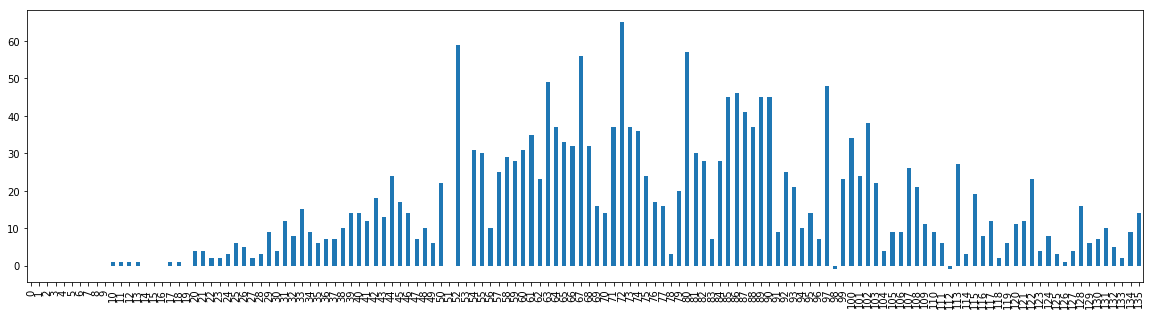

In [18]:
covidRecife['deaths_per_day'].plot(kind="bar", figsize=(20,5))

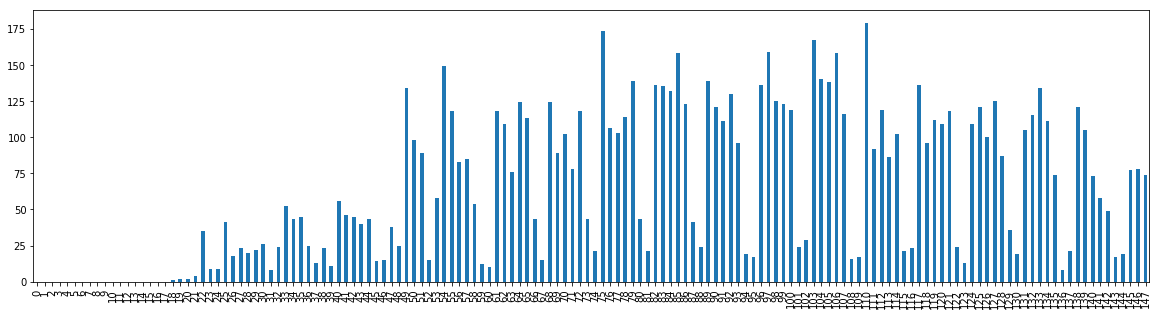

In [19]:
covidSP['deaths_per_day'].plot(kind="bar", figsize=(20,5))

Text(0.5, 0, 'dias')

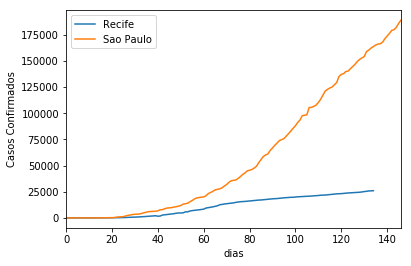

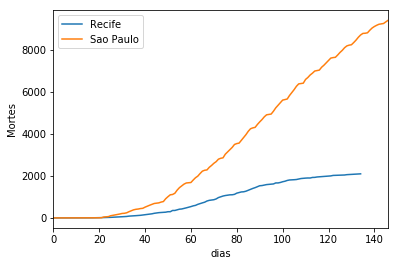

In [20]:
# comparação entre o número de casos confirmados totais em Recife (azul) e São Paulo (laranja)
crec_confirmed = covidRecife.confirmed[0:-1:1]
csp_confirmed = covidSP.confirmed[0:-1:1]
plot_confirmed = pd.concat([crec_confirmed, csp_confirmed], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes total em Recife (azul) e São Paulo (laranja)
crec_deaths = covidRecife.deaths[0:-1:1]
csp_deaths = covidSP.deaths[0:-1:1]
plot_deaths = pd.concat([crec_deaths, csp_deaths], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes')
plt.xlabel('dias')

# no grafico abaixo a cidade de São Paulo parece ter sido muito mais afetada do que Recife, pois temos uma curva de mortes muito maior

Text(0.5, 0, 'dias')

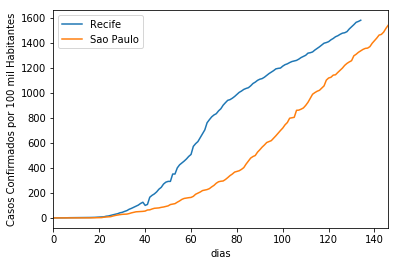

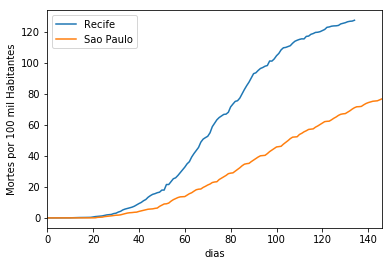

In [21]:
# Veremos agora o comparativo entre casos confirmados por 100 mil habitantes e mortes por 100 mil habitantes entre Recife e São Paulo

# comparação entre o número de casos confirmados por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_confirmed_per_100k_inhabitants = covidRecife.confirmed_per_100k_inhabitants[0:-1:1]
csp_confirmed_per_100k_inhabitants = covidSP.confirmed_per_100k_inhabitants[0:-1:1]
plot_confirmed_per_100k_inhabitants = pd.concat([crec_confirmed_per_100k_inhabitants, csp_confirmed_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados por 100 mil Habitantes')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_deaths_per_100k_inhabitants = covidRecife.deaths_per_100k_inhabitants[0:-1:1]
csp_deaths_per_100k_inhabitants = covidSP.deaths_per_100k_inhabitants[0:-1:1]
plot_deaths_per_100k_inhabitants = pd.concat([crec_deaths_per_100k_inhabitants, csp_deaths_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes por 100 mil Habitantes')
plt.xlabel('dias')

# no gráfico abaixo a cidade de Recife parece ter sido muito mais afetada do que São Paulo, pois temos uma curva maior em relação a casos confirmados/mortes por 100 mil habitantes

Text(0.5, 0, 'dias')

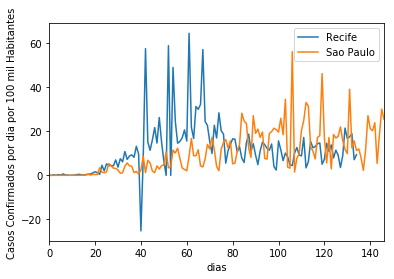

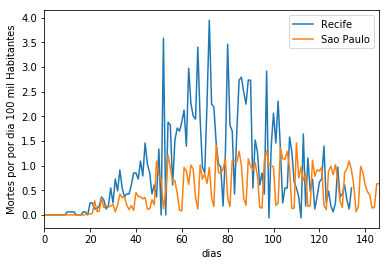

In [22]:

# comparação entre o número de casos confirmados por dia por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_confirmed_per_day_per_100k_inhabitants = covidRecife.confirmed_per_day_per_100k_inhabitants[0:-1:1]
csp_confirmed_per_day_per_100k_inhabitants = covidSP.confirmed_per_day_per_100k_inhabitants[0:-1:1]
plot_confirmed_per_day_per_100k_inhabitants = pd.concat([crec_confirmed_per_day_per_100k_inhabitants, csp_confirmed_per_day_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_confirmed_per_day_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Casos Confirmados por dia por 100 mil Habitantes')
plt.xlabel('dias')

# a mesma tendencia segue no número de mortes

# comparação entre o número de mortes por dia por 100 mil habitantes em Recife (azul) e São Paulo (laranja)
crec_deaths_per_day_per_100k_inhabitants = covidRecife.deaths_per_day_per_100k_inhabitants[0:-1:1]
csp_deaths_per_day_per_100k_inhabitants = covidSP.deaths_per_day_per_100k_inhabitants[0:-1:1]
plot_deaths_per_day_per_100k_inhabitants = pd.concat([crec_deaths_per_day_per_100k_inhabitants, csp_deaths_per_day_per_100k_inhabitants], axis=1, keys=['Recife', 'Sao Paulo'])
plot_deaths_per_day_per_100k_inhabitants.plot(kind='line', figsize=[6, 4])
plt.ylabel('Mortes por por dia 100 mil Habitantes')
plt.xlabel('dias')

# no gráfico abaixo a cidade de Recife parece ter sido muito mais afetada do que São Paulo, pois temos uma curva maior em relação a casos confirmados/mortes por 100 mil habitantes

In [23]:
# aqui eu reuno as informações sobre mortes por dia de ambas as cidades
crec_dp100k = covidRecife.deaths_per_day_per_100k_inhabitants[0:136:1]
csp_dp100k = covidSP.deaths_per_day_per_100k_inhabitants[0:136:1]

In [24]:
# aqui eu concateno ambos os DataFrames e coloco o nome de cada box usando o keys do concat
df_rec_sp = pd.concat([crec_dp100k, csp_dp100k], axis=1, keys=['deaths_per_day_per_100k_in_Recife', 'deaths_per_day_per_100k_in_Sao_Paulo'])

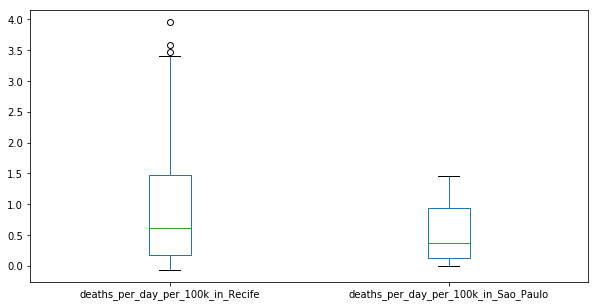

In [25]:
df_rec_sp.plot(kind='box', figsize=[10, 5])

In [26]:
# verificando se a diferença segue a gaussiana
# df_rec_sp['dpdp100k_difference'] = df_rec_sp.apply(lambda x: x['deaths_per_day_per_100k_in_Recife'] - x['deaths_per_day_per_100k_in_Sao_Paulo'], axis=1) or :
df_rec_sp['dpdp100k_difference'] = df_rec_sp['deaths_per_day_per_100k_in_Recife'] - df_rec_sp['deaths_per_day_per_100k_in_Sao_Paulo']
print(df_rec_sp)

     deaths_per_day_per_100k_in_Recife  deaths_per_day_per_100k_in_Sao_Paulo  \
0                             0.000000                              0.000000   
1                             0.000000                              0.000000   
2                             0.000000                              0.000000   
3                             0.000000                              0.000000   
4                             0.000000                              0.000000   
..                                 ...                                   ...   
131                           0.607634                              0.857001   
132                           0.303817                              0.938621   
133                           0.121527                              1.093697   
134                           0.546871                              0.905973   
135                           0.850688                              0.603982   

     dpdp100k_difference  
0           

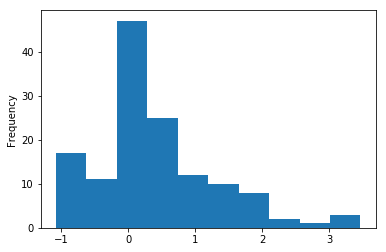

In [27]:
df_rec_sp['dpdp100k_difference'].plot(kind='hist')

In [28]:
# Shapiro-Wilk teste de normalidade que retorna o seguinte parametro: (valor, p-valor). Hipótese Nula: as mortes em Recife não são normalmente distribuídas.
stats.shapiro(df_rec_sp['dpdp100k_difference'])

# um p-valor menor que o valor crítico indica que a hipótese nula foi rejeitada / shapiro => retorn (valor crítico, p-valor)

(0.9259416460990906, 1.5153243566601304e-06)

In [29]:
# executando o t-test
stats.ttest_rel(df_rec_sp['deaths_per_day_per_100k_in_Recife'], df_rec_sp['deaths_per_day_per_100k_in_Sao_Paulo'])

Ttest_relResult(statistic=5.38246564972097, pvalue=3.158163070386272e-07)

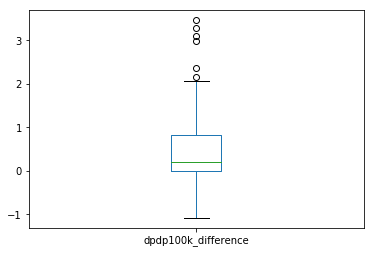

In [32]:
# checando simetria
df_rec_sp['dpdp100k_difference'].plot(kind='box')

In [162]:
stats.wilcoxon(df_rec_sp['deaths_per_day_per_100k_in_Recife'], df_rec_sp['deaths_per_day_per_100k_in_Sao_Paulo'])

WilcoxonResult(statistic=1887.0, pvalue=1.8995295363544549e-06)